This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [3]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.data.dc08d import sims_interface
sims_lerepi  = sims_interface.ILC_May2022('00')


simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

# Check mask

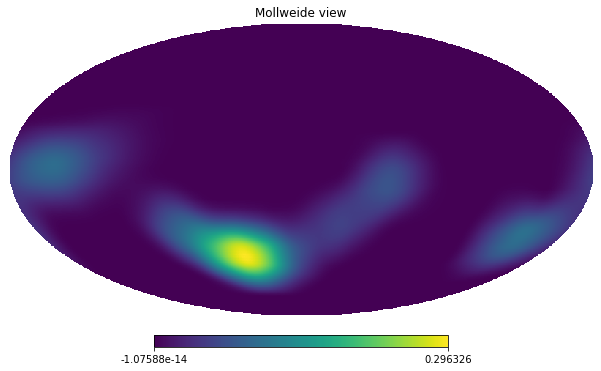

In [4]:
mask = sims_lerepi.get_mask()
hp.mollview(mask)

# Display maps / noise

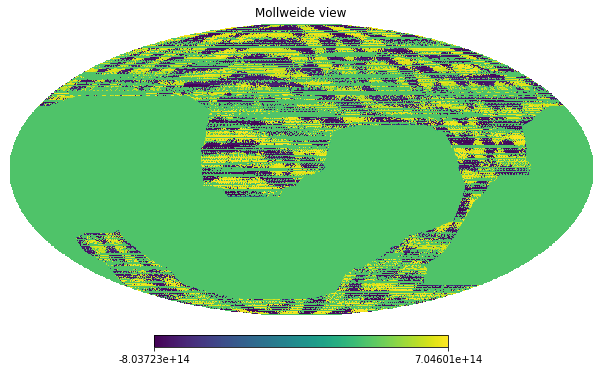

In [8]:
q, u = sims_lerepi.get_sim_pmap(0)
hp.mollview(q, norm='hist')

In [6]:
Cl = ps.map2cl_spin([q,u], spin=2, mask=mask, lmax=lmax-1, lmax_mask=lmax)

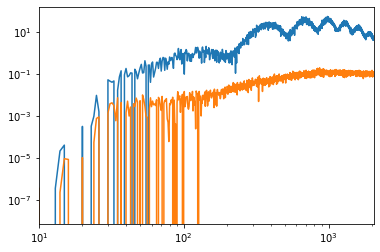

In [21]:
plt.plot(Cl[0]*scale_ps)
plt.plot(Cl[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

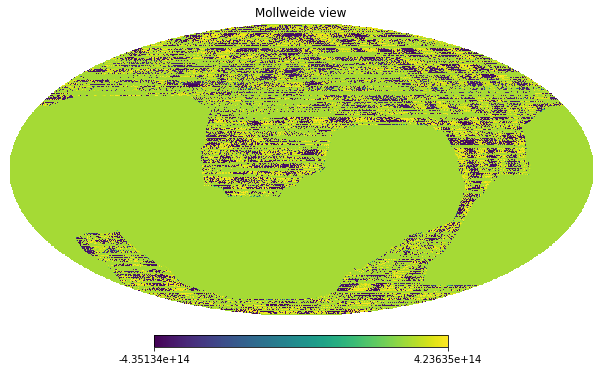

In [24]:
Nq, Nu = sims_lerepi.get_noise_sim_pmap(0)
hp.mollview(Nq, norm='hist')

In [27]:
ClN = ps.map2cl_spin([Nq,Nu], spin=2, mask=mask, lmax=lmax, lmax_mask=lmax)

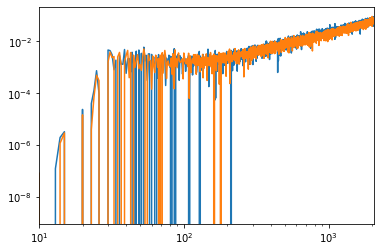

In [28]:
plt.plot(ClN[0]*scale_ps)
plt.plot(ClN[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

# Derive transferfunction

In [102]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

In [30]:
def TEBlm_f(simidx):
    '''
    Returns fiducial ffp10 powerspectrum
    '''
    ffp10scalmTEB = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ffp10scalmTEB

tebmap_f = np.array([hp.alm2map(TEBlm_f(simidx), nside=2048, pol=False) for simidx in simids]) # almTEB -> mapTEB

In [63]:
ClEE_f = ps.map2cl(tebmap_f[0,1], mask=mask, lmax=lmax, lmax_mask=lmax)
ClBB_f = ps.map2cl(tebmap_f[0,2], mask=mask, lmax=lmax, lmax_mask=lmax)

In [ ]:
Cl_fxD = ps.map2cl(tebmap_f[0,1]-, mask=mask, lmax=lmax, lmax_mask=lmax)

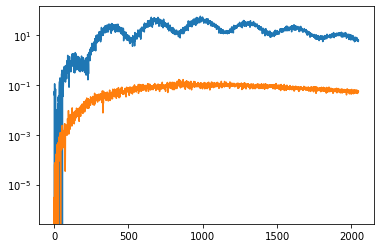

In [64]:
plt.plot(ClEE_f*scale_ps)
plt.plot(ClBB_f*scale_ps)
plt.yscale('log')

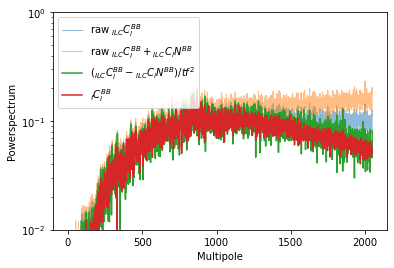

In [105]:
plt.plot(Cl[1]*scale_ps, label=r'raw $_{ILC}C_l^{BB}$', lw=1, alpha=0.5)
plt.plot((Cl[1]+ClN[1])*scale_ps, label=r'raw $_{ILC}C_l^{BB}+_{ILC}C_lN^{BB}$', lw=1, alpha=0.5)
# plt.plot(1/tf**2, label=r"$Tf^{2'3''}_p$")

plt.plot((Cl[1]-ClN[1])*scale_ps/tf[:2048]**2, label=r'$(_{ILC}C_l^{BB} -_{ILC}C_lN^{BB}) /tf^2$')
plt.plot(ClBB_f*scale_ps, label=r'$_fC_l^{BB}$')

plt.yscale('log')
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

plt.ylim((1e-2,1e0))
plt.legend()

# Check masks

In [114]:
mask_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
mask_chiledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

TypeError: read_map() got an unexpected keyword argument 'title'

In [1]:
hp.mollview(mask_n2048, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
hp.mollview(mask_chiledeep, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

NameError: name 'hp' is not defined

In [118]:
mask_poledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/pole_deep_2048.fits')
mask_pole_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/n2048.fits')

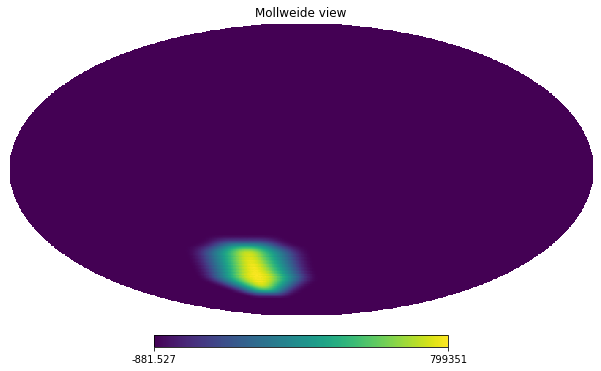

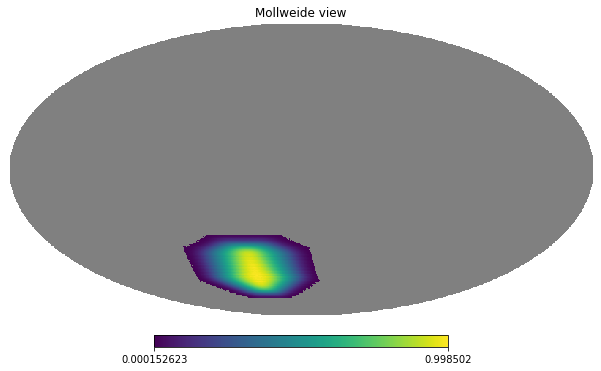

In [119]:
hp.mollview(mask_pole_n2048)
hp.mollview(mask_poledeep)

# Calculate central noise levels

## Build noise template

In [ ]:
cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clg_templ = cls_len['ee']
clc_templ = cls_len['bb']

In [5]:
from component_separation.MSC.MSC import pospace as ps
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
lmax_cl = 2048
lmax_lib = 3*lmax_cl-1
ps.map2cl_binned(mask, clc_templ[:lmax_lib], cmbs4_edges, lmax_lib)

NameError: name 'clc_templ' is not defined